In [1]:
import os
import pandas as pd
import seaborn as sns
from PIL import Image
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import visualkeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pydot
import graphviz
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D

In [2]:
# PART ONE: DATA PREPROCESSING & PREPARATION

In [3]:
# Loading in the dataset

trainDataset = pd.read_csv('./roadsigns/train/_classes.csv')
trainDataset['filename'] = './roadsigns/train/' + trainDataset['filename']

validationDataset = pd.read_csv('./roadsigns/valid//_classes.csv')
validationDataset['filename'] = './roadsigns/valid/' + validationDataset['filename']

In [4]:
# Checking if there are any data objects with null/improper values

numTrainEntriesNull = trainDataset.isnull().sum()
print("Train:")
print(numTrainEntriesNull)
print()

numValidationEntriesNull = validationDataset.isnull().sum()
print("Validation:")
print(numValidationEntriesNull)
print()

Train:
filename                                0
 -Road narrows on right                 0
 50 mph speed limit                     0
 Attention Please-                      0
 Beware of children                     0
 CYCLE ROUTE AHEAD WARNING              0
 Dangerous Left Curve Ahead             0
 Dangerous Rright Curve Ahead           0
 End of all speed and passing limits    0
 Give Way                               0
 Go Straight or Turn Right              0
 Go straight or turn left               0
 Keep-Left                              0
 Keep-Right                             0
 Left Zig Zag Traffic                   0
 No Entry                               0
 No_Over_Taking                         0
 Overtaking by trucks is prohibited     0
 Pedestrian Crossing                    0
 Round-About                            0
 Slippery Road Ahead                    0
 Speed Limit 20 KMPh                    0
 Speed Limit 30 KMPh                    0
 Stop_Sign                 

In [5]:
# Checking for classes that heavily skew the data

for column in trainDataset.columns[1:]:
  print(column, ":", trainDataset[column].sum(), "samples")

 -Road narrows on right : 213 samples
 50 mph speed limit : 245 samples
 Attention Please- : 473 samples
 Beware of children : 429 samples
 CYCLE ROUTE AHEAD WARNING : 214 samples
 Dangerous Left Curve Ahead : 167 samples
 Dangerous Rright Curve Ahead : 288 samples
 End of all speed and passing limits : 191 samples
 Give Way : 425 samples
 Go Straight or Turn Right : 305 samples
 Go straight or turn left : 166 samples
 Keep-Left : 236 samples
 Keep-Right : 324 samples
 Left Zig Zag Traffic : 263 samples
 No Entry : 332 samples
 No_Over_Taking : 0 samples
 Overtaking by trucks is prohibited : 191 samples
 Pedestrian Crossing : 190 samples
 Round-About : 292 samples
 Slippery Road Ahead : 403 samples
 Speed Limit 20 KMPh : 21 samples
 Speed Limit 30 KMPh : 1 samples
 Stop_Sign : 121 samples
 Straight Ahead Only : 264 samples
 Traffic_signal : 32 samples
 Truck traffic is prohibited : 335 samples
 Turn left ahead : 333 samples
 Turn right ahead : 326 samples
 Uneven Road : 312 samples


In [6]:
# Saving class names for later use

class_columns =  [" -Road narrows on right",
                " 50 mph speed limit",
                " Attention Please-",
                " Beware of children",
                " CYCLE ROUTE AHEAD WARNING",
                " Dangerous Left Curve Ahead",
                " Dangerous Rright Curve Ahead",
                " End of all speed and passing limits",
                " Give Way",
                " Go Straight or Turn Right",
                " Go straight or turn left",
                " Keep-Left",
                " Keep-Right",
                " Left Zig Zag Traffic",
                " No Entry",
                # " No_Over_Taking",
                " Overtaking by trucks is prohibited",
                " Pedestrian Crossing",
                " Round-About",
                " Slippery Road Ahead",
                # " Speed Limit 20 KMPh",
                # " Speed Limit 30 KMPh",
                " Stop_Sign",
                " Straight Ahead Only",
                " Traffic_signal",
                " Truck traffic is prohibited",
                " Turn left ahead",
                " Turn right ahead",
                " Uneven Road"]

In [7]:
# Dropping data objects belonging to the classes that heavily skew the data

trainDataset = trainDataset[
    (trainDataset[' Speed Limit 20 KMPh'] != 1) &
    (trainDataset[' Speed Limit 30 KMPh'] != 1)
].copy()
trainDataset.drop([' Speed Limit 30 KMPh', ' No_Over_Taking', ' Speed Limit 20 KMPh'], axis=1, inplace=True) 

validationDataset = validationDataset[
    (validationDataset[' Speed Limit 20 KMPh'] != 1) &
    (validationDataset[' Speed Limit 30 KMPh'] != 1)
].copy()
validationDataset.drop([' Speed Limit 30 KMPh', ' No_Over_Taking', ' Speed Limit 20 KMPh'], axis=1, inplace=True) 

In [8]:
# Splitting the data into training and testing sets

trainDataset, testDataset = train_test_split(trainDataset, test_size = 0.2, random_state = 42)

In [9]:
# Resizing and normalizing pixel values for training/validating/testing the CNN

trainFiles = trainDataset['filename'].values
trainClasses = trainDataset[class_columns].values

valFiles = validationDataset['filename'].values
valClasses = validationDataset[class_columns].values

testFiles = testDataset['filename'].values
testClasses = testDataset[class_columns].values

def load_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0
    return image, label

def preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0
    return image

X_test = np.array([preprocess_image(file).numpy() for file in testFiles])
y_test = np.array(testClasses)

train_ds = tf.data.Dataset.from_tensor_slices((trainFiles, trainClasses))
train_ds = train_ds.map(load_image).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((valFiles, valClasses))
val_ds = val_ds.map(load_image).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((testFiles, testClasses))
test_ds = test_ds.map(load_image).batch(32)

In [10]:
# PART TWO: BUILDING & TRAINING THE MODEL

In [11]:
train_ds = train_ds.shuffle(buffer_size=32)

model = Sequential([
  #layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_columns))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 18)

In [13]:
epochs=5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = [early_stop]
)

Epoch 1/5


2024-11-26 13:13:16.242021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5656,26]
	 [[{{node Placeholder/_1}}]]
2024-11-26 13:13:16.242124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5656,26]
	 [[{{node Placeholder/_1}}]]
2024-11-26 13:13:16.412536: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


177/177 [==============================] - ETA: 0s - loss: 1.3296 - accuracy: 0.6326

2024-11-26 13:13:27.102678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1761,26]
	 [[{{node Placeholder/_1}}]]


177/177 [==============================] - 12s 67ms/step - loss: 1.3296 - accuracy: 0.6326 - val_loss: 0.5057 - val_accuracy: 0.8427
Epoch 2/5
177/177 [==============================] - 12s 66ms/step - loss: 0.2249 - accuracy: 0.9443 - val_loss: 0.3209 - val_accuracy: 0.9160
Epoch 3/5
177/177 [==============================] - 12s 65ms/step - loss: 0.1007 - accuracy: 0.9793 - val_loss: 0.1670 - val_accuracy: 0.9659
Epoch 4/5
177/177 [==============================] - 12s 66ms/step - loss: 0.0444 - accuracy: 0.9910 - val_loss: 0.1679 - val_accuracy: 0.9693
Epoch 5/5
177/177 [==============================] - 12s 67ms/step - loss: 0.0509 - accuracy: 0.9883 - val_loss: 0.2477 - val_accuracy: 0.9478


In [14]:
# PART THREE: TESTING THE MODEL & EVALUATING PERFORMANCE

In [15]:
model.evaluate(test_ds, batch_size=32)

 5/45 [==>...........................] - ETA: 1s - loss: 0.1835 - accuracy: 0.9688

2024-11-26 13:14:16.023160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1414,26]
	 [[{{node Placeholder/_1}}]]


45/45 [==============================] - 1s 25ms/step - loss: 0.2941 - accuracy: 0.9519


[0.2940983176231384, 0.9519094824790955]

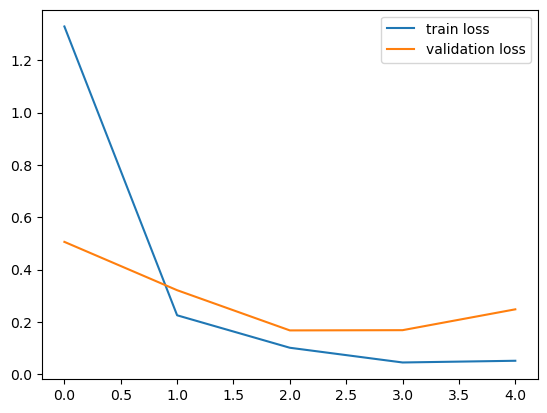

In [16]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

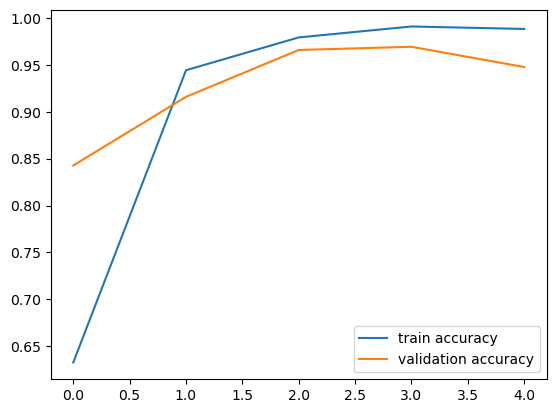

In [17]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [18]:
predictions = model.predict(X_test)
predictions_classes = np.argmax(predictions, axis = 1)
y_true = np.argmax(y_test, axis = 1)
print(confusion_matrix(y_true, predictions_classes))
img_path = '/Users/vickieluo/downloads/roadsign/test/00001_00060_00025_png_jpg.rf.000c35625c7010cffe4f4cbc61d51afb.jpg'

45/45 [==============================] - 1s 19ms/step
[[33  0  0  0  0  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0 51  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0 90  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0 75  1  1  6  1  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0
   0  0]
 [ 0  0  0  0 32  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0 29  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0]
 [ 0  0  0  1  0  0 59  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1]
 [ 0  0  0  0  0  0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0 72  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  3  0 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  

Visualizing feature maps for layer 1


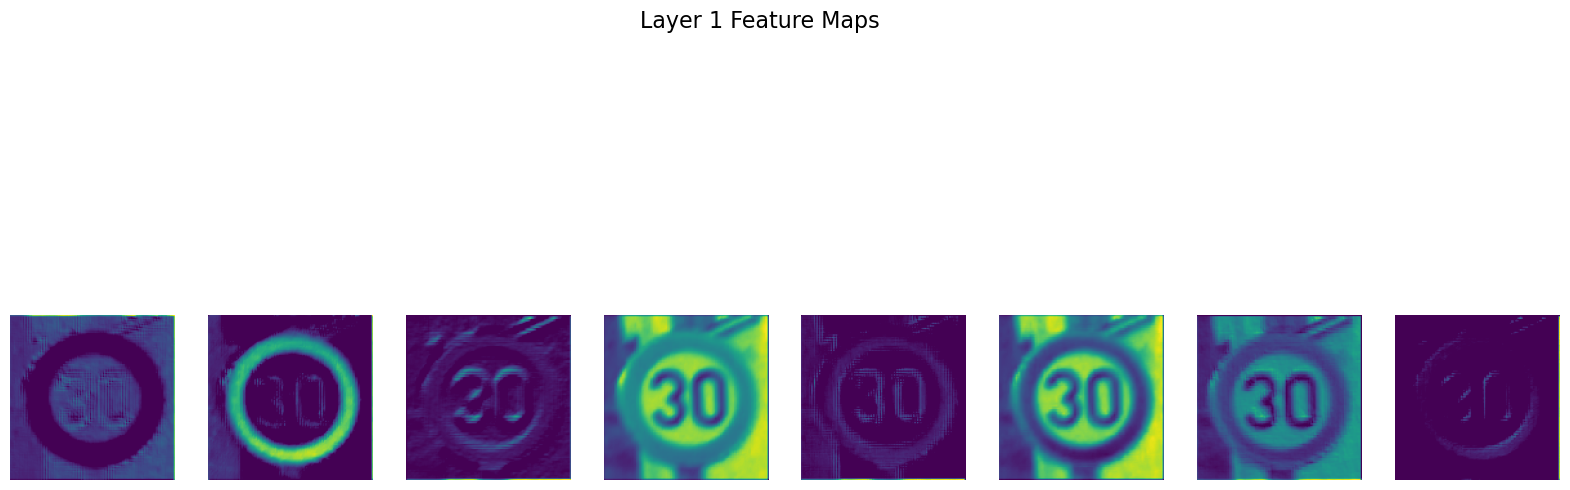

Visualizing feature maps for layer 2


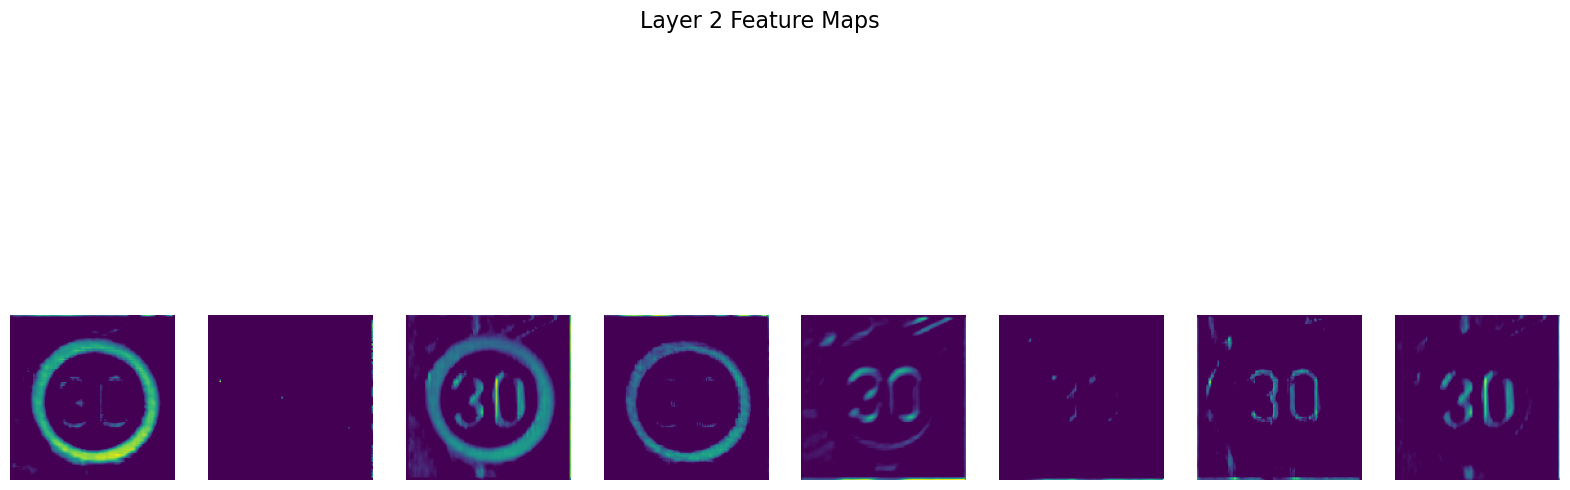

In [19]:
img_path = './roadsigns/test/00001_00060_00025_png_jpg.rf.000c35625c7010cffe4f4cbc61d51afb.jpg'
  # Replace with your image path
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img) / 255.0  
img_array = np.expand_dims(img_array, axis=0) 

intermediate_outputs = []

current_input = img_array  
for layer in model.layers:
    if isinstance(layer, Conv2D): 
        current_input = layer(current_input)  
        intermediate_outputs.append(current_input) 

def visualize_feature_maps(feature_maps):
    for layer_index, feature_map in enumerate(feature_maps):
        print(f"Visualizing feature maps for layer {layer_index + 1}")

        num_filters = feature_map.shape[-1]

        fig, axes = plt.subplots(1, min(8, num_filters), figsize=(20, 8))
        fig.suptitle(f"Layer {layer_index + 1} Feature Maps", fontsize=16)

        for i in range(min(8, num_filters)):  
            ax = axes[i]
            ax.imshow(feature_map[0, :, :, i], cmap='viridis') 
            ax.axis('off')
        plt.show()

visualize_feature_maps(intermediate_outputs)

45/45 [==============================] - 1s 18ms/step


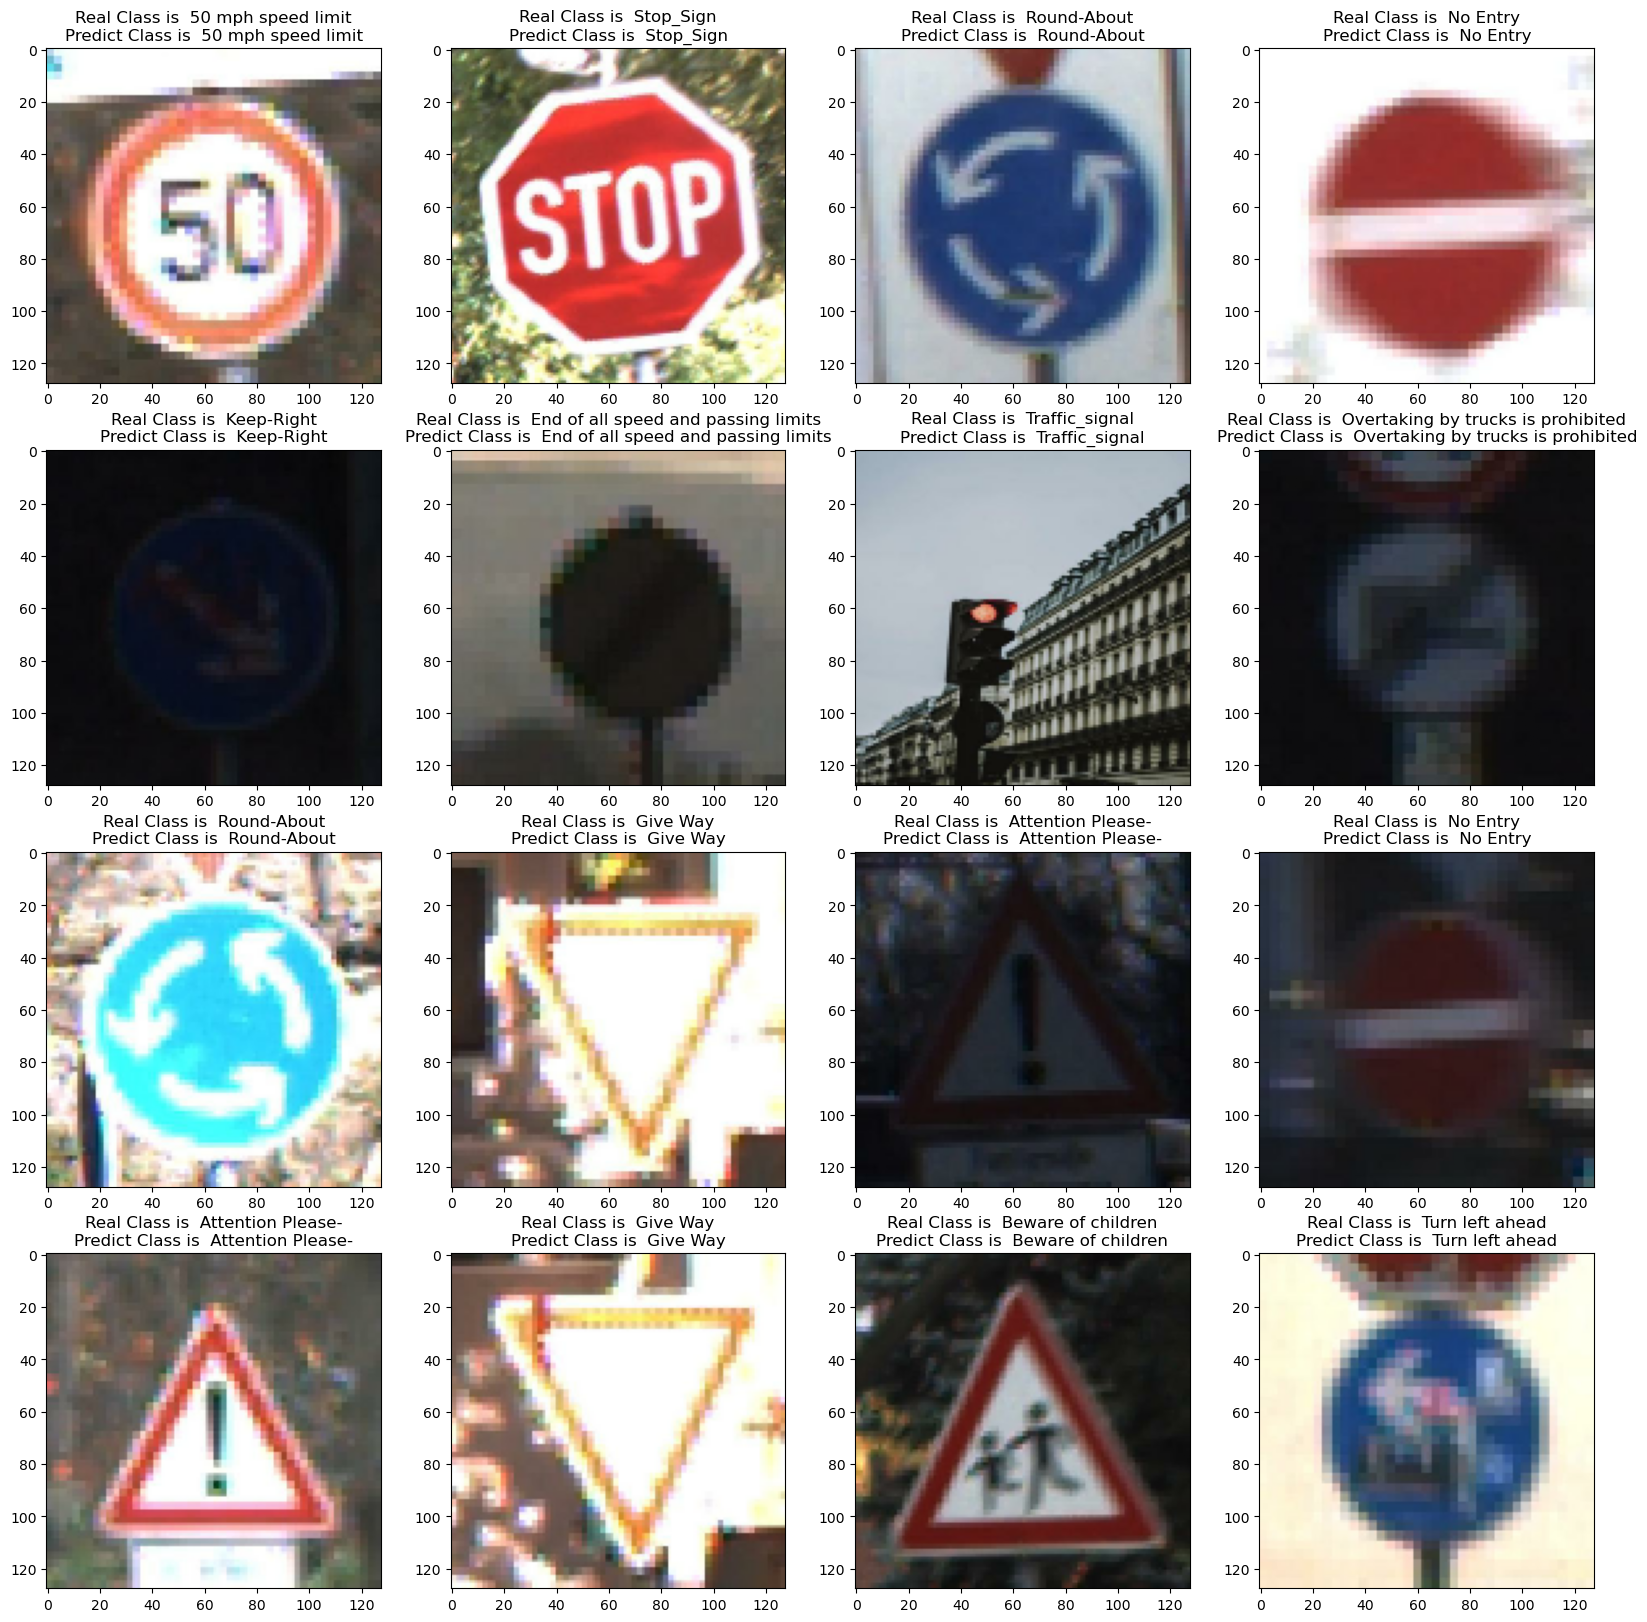

In [20]:
predictions = model.predict(X_test)
X_test_reshape = X_test.reshape(X_test.shape[0], 128, 128, 3)

fig, axis = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axis.flat):
    if len(X_test_reshape.shape) == 3: 
        ax.imshow(X_test_reshape[i], cmap='gray')
    elif len(X_test_reshape.shape) == 4: 
        ax.imshow(X_test_reshape[i])
    ax.set(title = f"Real Class is {class_columns[y_test[i].argmax()]}\nPredict Class is {class_columns[predictions[i].argmax()]}");
plt.show()